# Описание

**Цель:** Проверка метода выявления вредоносного кода PowerShell, описанного в статье от Angara Security https://habr.com/ru/companies/angarasecurity/articles/751858/

Авторы статьи использовали другую статью и репозиторий: 
- Effective method for detecting malicious PowerShell scripts based on hybrid features https://www.sciencedirect.com/science/article/abs/pii/S0925231221005099?via%3Dihub
- https://github.com/das-lab/mpsd

В отличие от оригинальной статьи, где использовался Random Forest, авторы использовали Bi-LSTM. Хотя все не совсем так, и не смотря на то, что авторы использовали Random Forest для окончательной классификации, основная часть там про выделение признаков (feature engineering) и обучение эмбеддингов (fast text).

**Задачи:**
1. Реализовать подход, описанный в статье

**Данные:**

Данные, использованные в статье:

- **malicious_pure** содержит образцы вредоносного кода;
- **powershell_benign_dataset** содержит легитимные образцы кода;
- **mixed_malicious** в легитимный код встроены вредоносные элементы - не тестировались


# Библиотеки, модули, функции

In [138]:
import os
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(1234)


In [139]:
def read_files(path):
    dataset = []

    for filename in os.listdir(path):
        if re.match("^\d", filename): # работаем пока над скриптами не для git или CS
            filename_old = filename
            filename = os.path.join(path, filename.split('.')[0] + '.txt')
            os.rename(os.path.join(path, filename_old), filename)

            try:
            
                with open(filename, 'r', encoding = 'utf-8') as f:
                    line = f.read().replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
                    dataset.append(re.sub(r'\s+', ' ', line))
            except PermissionError as exc:
                print(exc)                

            os.rename(filename, os.path.join(path, filename_old))
            
    return dataset

# 1. Работа с данными из статьи

## 1.1. Загрузка данных

Данные можно скачать отсюда: https://github.com/das-lab/mpsd

In [140]:
malicious = read_files('mpsd/malicious_pure')
valid = read_files('mpsd/powershell_benign_dataset')
mixed = read_files('mpsd/mixed_malicious')

Вредоносы

In [141]:
df_malicious = pd.DataFrame(malicious, columns=['data'])
df_malicious['label'] = 1
df_malicious

,data,label
0,"$usQ9 = '[DllImport(""kernel32.dll"")]public st...",1
1,"$c = '[DllImport(""kernel32.dll"")]public stati...",1
2,(New-Object System.Net.WebClient).DownloadFil...,1
3,"$TaskName = ""Microsoft Windows Driver Update""...",1
4,$wc=New-OBjecT SysteM.NeT.WebClIeNT;$u='Mozil...,1
...,...,...
4049,"$c = '[DllImport(""kernel32.dll"")]public stati...",1
4050,"$c = '[DllImport(""kernel32.dll"")]public stati...",1
4051,dir c:\;sleep(5);Set-ExecutionPolicy Bypass -...,1
4052,(New-Object System.Net.WebClient).DownloadFil...,1


In [143]:
df_malicious['data'].sample(1).values[0]

' $Xn9 = \'[DllImport("kernel32.dll")]public static extern IntPtr VirtualAlloc(IntPtr lpAddress, uint dwSize, uint flAllocationType, uint flProtect);[DllImport("kernel32.dll")]public static extern IntPtr CreateThread(IntPtr lpThreadAttributes, uint dwStackSize, IntPtr lpStartAddress, IntPtr lpParameter, uint dwCreationFlags, IntPtr lpThreadId);[DllImport("msvcrt.dll")]public static extern IntPtr memset(IntPtr dest, uint src, uint count);\';$w = Add-Type -memberDefinition $Xn9 -Name "Win32" -namespace Win32Functions -passthru;[Byte[]];[Byte[]]$z = 0xb8,0xf8,0xdf,0x16,0x01,0xda,0xc1,0xd9,0x74,0x24,0xf4,0x5d,0x2b,0xc9,0xb1,0x47,0x83,0xed,0xfc,0x31,0x45,0x0f,0x03,0x45,0xf7,0x3d,0xe3,0xfd,0xef,0x40,0x0c,0xfe,0xef,0x24,0x84,0x1b,0xde,0x64,0xf2,0x68,0x70,0x55,0x70,0x3c,0x7c,0x1e,0xd4,0xd5,0xf7,0x52,0xf1,0xda,0xb0,0xd9,0x27,0xd4,0x41,0x71,0x1b,0x77,0xc1,0x88,0x48,0x57,0xf8,0x42,0x9d,0x96,0x3d,0xbe,0x6c,0xca,0x96,0xb4,0xc3,0xfb,0x93,0x81,0xdf,0x70,0xef,0x04,0x58,0x64,0xa7,0x27,0x49,0x3b,0xbc,0x

### Проверка вредоносных скриптов на virustotal.com

In [198]:
import json
import requests
import time

scan_url = 'https://www.virustotal.com/vtapi/v2/file/scan'
report_url = 'https://www.virustotal.com/vtapi/v2/file/report'
params = dict(apikey='b64194956ebf7833f1fbdc26af11385603f9ee4379ea91e6f20b9230a90c0f05')

In [215]:
i = 0

df_result = pd.DataFrame()

for file in os.listdir('mpsd/malicious_pure/')[:200]:
    
    if i > 100: break
            
    file_path = f"mpsd/malicious_pure/{file}"
    with open(file_path, 'rb') as f:
        files = dict(file=(file_path, f))
        response = requests.post(scan_url, files=files, params=params)

    if response.status_code == 200:
        result=response.json()
        params['resource'] = result['scan_id']
        
        response = requests.get(report_url, params=params)
        
        for i in range(5):
            if response.status_code != 200:
                time.sleep(20)
                response = requests.get(report_url, params=params)
                continue
            
            result=response.json()
            
            if result['response_code']==-2:
                time.sleep(20)
                response = requests.get(report_url, params=params)
                continue
                
            result=response.json()
            
        try:
            file_report = pd.DataFrame(result['scans']).loc['detected']
            file_report['_positives'] = result['positives']
            file_report['_file'] = file
            
            df_result = pd.concat([df_result, file_report], axis=1)  
            print(f"{file}: {result['positives']}")

            i += 1
        except KeyError:
            continue
                
        del params['resource']
        
    else:
        print('!!', response.status_code)
        
    time.sleep(20)
    
df_result.to_csv('virustotal_result.csv')

1477.ps1: 28
1895.ps1: 28
2494.ps1: 21
60.ps1: 10
3288.ps1: 12
1429.ps1: 29
3451.ps1: 26
2752.ps1: 0
3770.ps1: 13
707.ps1: 18
1399.ps1: 4
761.ps1: 24
2453.ps1: 28
2718.ps1: 25
1041.ps1: 27
987.ps1: 24
3159.ps1: 28
2014.ps1: 28
3913.ps1: 24
927.ps1: 27
4041.ps1: 1
2112.ps1: 30
2641.ps1: 25
2505.ps1: 25
2447.ps1: 24
1155.ps1: 27
74.ps1: 24
git_131.ps1: 35
2280.ps1: 11
3112.ps1: 20
2632.ps1: 16
2543.ps1: 28
277.ps1: 31
3481.ps1: 26
1199.ps1: 10
3058.ps1: 27
1858.ps1: 24
2994.ps1: 26
3535.ps1: 24
262.ps1: 24
226.ps1: 21
171.ps1: 24
1010.ps1: 32
1357.ps1: 27
100.ps1: 31
3300.ps1: 22
368.ps1: 26
3983.ps1: 25
181.ps1: 25
982.ps1: 0
1537.ps1: 27
547.ps1: 4
1240.ps1: 24
2406.ps1: 24
2684.ps1: 24
139.ps1: 0
965.ps1: 28
336.ps1: 27
221.ps1: 24
1488.ps1: 28
3672.ps1: 29
623.ps1: 24
1233.ps1: 27
637.ps1: 27
git_76.ps1: 19
2040.ps1: 29
3939.ps1: 28
402.ps1: 31
3814.ps1: 25
2312.ps1: 4
1186.ps1: 24
2973.ps1: 29
2209.ps1: 29
77.ps1: 4
939.ps1: 24
2464.ps1: 26
1120.ps1: 32
29.ps1: 36
968.ps1: 33
321.ps

KeyboardInterrupt: 

In [ ]:
df_result = df_result.T
df_result.index = df_result.pop('_file')

Количество вредоносных скриптов: 129


'Количество нераспознанных вредоносных скриптов: 5 (3.9%)'

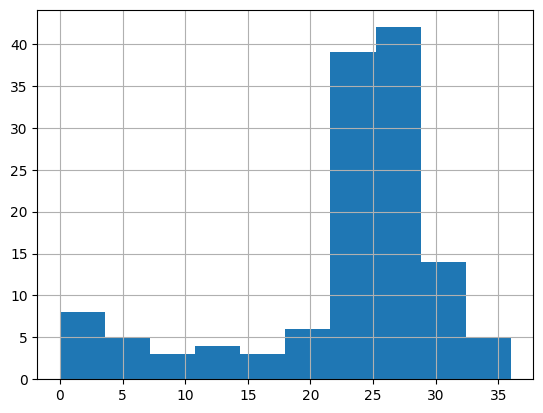

In [225]:
df_result['_positives'].hist(bins=10)
not_detected = df_result[df_result['_positives']==0].shape[0]
print("Количество вредоносных скриптов:", df_result.shape[0])
f"Количество нераспознанных вредоносных скриптов: {not_detected} ({not_detected/df_result.shape[0]:.1%})"

**Вывод:** бОльшая часть скриптов была обнаружена антивирусным ПО, не были распознаны менее 5% скриптов

"Чистые" скрипты

In [5]:
df_valid = pd.DataFrame(valid, columns=['data'])
df_valid['label'] = 0
df_valid

,data,label
0,function Set-ModuleNuspec { param( [Parameter...,0
1,"Describe ""Write-Error Tests"" -Tags ""CI"" { It ...",0
2,"$ServiceName = ""SQL Server (SOX2)"" $TranManSe...",0
3,function Invoke-Inveigh { [CmdletBinding()] pa...,0
4,function Get-AuthToken { [cmdletbinding()] pa...,0
...,...,...
4311,﻿ function Connect-SCP{ param ( [parameter(Man...,0
4312,function Test-CSslCertificateBinding { [Cmdle...,0
4313,class Room { [string]$Id [string]$Name [strin...,0
4314,﻿function Get-ADMigratedSourceObject { [cmdlet...,0


Общий датасет

In [6]:
df_all = pd.concat([df_malicious, df_valid])
df_all

,data,label
0,"$usQ9 = '[DllImport(""kernel32.dll"")]public st...",1
1,"$c = '[DllImport(""kernel32.dll"")]public stati...",1
2,(New-Object System.Net.WebClient).DownloadFil...,1
3,"$TaskName = ""Microsoft Windows Driver Update""...",1
4,$wc=New-OBjecT SysteM.NeT.WebClIeNT;$u='Mozil...,1
...,...,...
4311,﻿ function Connect-SCP{ param ( [parameter(Man...,0
4312,function Test-CSslCertificateBinding { [Cmdle...,0
4313,class Room { [string]$Id [string]$Name [strin...,0
4314,﻿function Get-ADMigratedSourceObject { [cmdlet...,0


Датасет с подмешанными в чистные скрипты вредоносными участками (не используется)

In [7]:
df_mixed = pd.DataFrame(mixed, columns=['data'])
df_mixed['label'] = 1
df_mixed

,data,label
0,function Expand-CItem { [OutputType([IO.Direc...,1
1,﻿function Get-SCCMDeviceCollectionDeployment {...,1
2,﻿ param([string]$DName ) configuration LabDC_D...,1
3,﻿ function Test-Run { $dfname = Get-DataFactor...,1
4,"Write-Host ""Installing Pester"" -ForegroundColo...",1
...,...,...
4049,function Get-AuthToken { [cmdletbinding()] pa...,1
4050,﻿ Update-TypeData -TypeName System.Diagnostics...,1
4051,function Get-AuthToken { [cmdletbinding()] pa...,1
4052,function Uninstall-CUser { [CmdletBinding(Sup...,1


## 1.2. Подготовка данных

Пока не будем заморачиваться с подготовкой, возьмем ее из статьи:
1) Заменим громоздкие массивы Base64, которые встречаются в коде на наш единый токен base64_string. Для модели подобные массивы будут бесполезны, т.к. будет много уникальных значений. Модель будет анализировать информацию в виде чисел и не сможет отличить Base64, скажем, от другого слова. Введение подобного токена поможет акцентировать на этом внимание.

2) Заменим IP адреса на два вида токенов: external_ip для внешних адресов и internal_ip для внутренних. IP адреса встречаются как в легитимном коде, так и во вредоносном, при этом нам совершенно не важно, что это за адрес. Достаточно понимать, внутренний он или внешний.

3) Часть спецсимволов будем использовать как разделитель. Скобки, кавычки и прочие элементы кода не несут особой смысловой нагрузки для решения нашей задачи, при этом мы будем использовать их в качестве разделителя и заменим на пробел.

4) Удалим лишние пробелы и мусор для того, чтобы уменьшить объем кода.

5) Приведем все символы к нижнему регистру, чтобы стандартизировать токены.

In [8]:
def clean_data_to_tokens(dataset):
    tokens = []
    char_replace = "()[]{},;'/\=:^<>|`+\""
    for source_string in dataset:
        source_string = re.sub("FromBase64String\(\'(.*)\'\)", "base64_string", source_string)
        source_string = re.sub("([a-zA-Z0-9\/\+=]{100,})+", "base64_string", source_string)
        for char in char_replace:
            source_string = source_string.replace(char, ' ')
        source_string = re.sub(r"(?<!\S)\d+(?!\S)", " ", source_string)
        source_string = re.sub(r"0x\S+", " ", source_string)
        ip_addresses = re.findall(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)', source_string)
        for ip in ip_addresses:
            if ip.startswith('10.') or ip.startswith('192.') or ip.startswith('172.16.') or ip.startswith('127.0.'):
                source_string = source_string.replace(ip, 'internal_ip')
            else:
                source_string = source_string.replace(ip, 'external_ip')
        source_string = source_string.replace('.', ' ')
        tokens.append(re.sub(r'\s+', ' ', source_string.lower()))
    return tokens


In [9]:
# Обрабатываем данные
df_all['tokenized'] = clean_data_to_tokens(df_all['data'].values)
df_all['tokenized_len'] = df_all['tokenized'].apply(lambda x: len(x.split()))
df_all

,data,label,tokenized,tokenized_len
0,"$usQ9 = '[DllImport(""kernel32.dll"")]public st...",1,$usq9 dllimport kernel32 dll public static ex...,95
1,"$c = '[DllImport(""kernel32.dll"")]public stati...",1,$c dllimport kernel32 dll public static exter...,95
2,(New-Object System.Net.WebClient).DownloadFil...,1,new-object system net webclient downloadfile ...,19
3,"$TaskName = ""Microsoft Windows Driver Update""...",1,$taskname microsoft windows driver update $ta...,109
4,$wc=New-OBjecT SysteM.NeT.WebClIeNT;$u='Mozil...,1,$wc new-object system net webclient $u mozill...,66
...,...,...,...,...
4311,﻿ function Connect-SCP{ param ( [parameter(Man...,0,﻿ function connect-scp param parameter mandato...,141
4312,function Test-CSslCertificateBinding { [Cmdle...,0,function test-csslcertificatebinding cmdletbi...,39
4313,class Room { [string]$Id [string]$Name [strin...,0,class room string $id string $name string $to...,48
4314,﻿function Get-ADMigratedSourceObject { [cmdlet...,0,﻿function get-admigratedsourceobject cmdletbin...,678


<Axes: title={'center': 'tokenized_len'}, xlabel='label'>

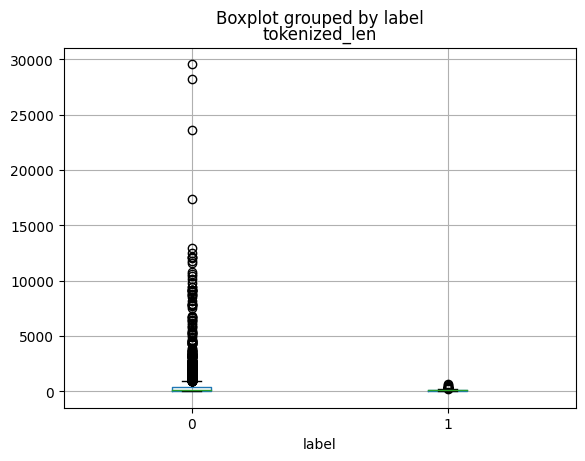

In [10]:
df_all.boxplot('tokenized_len', by='label')

In [11]:
df_all['tokenized_len'].describe()

count     8370.000000
mean       274.059618
std        938.681900
min          2.000000
25%         38.000000
50%         95.000000
75%        175.000000
max      29572.000000
Name: tokenized_len, dtype: float64

In [12]:
token_len = int(df_all['tokenized_len'].quantile(0.99))
print(token_len)

3271


В статье принимается длина токенов 2000, пока оставим так

In [13]:
token_len = 2000

In [14]:
# Cловарь с уникальными токенами
def dataset_vocab(input_data):
    unique_words = {}
    for data in input_data:
        words = data.split()
        for word in words:
            if word not in unique_words:
                unique_words[word] = 1
            else:
                unique_words[word] += 1
    # Сортируем словарь от большего к меньшему
    sorted_unique_words = {k:v for k,v in sorted(unique_words.items(), key=lambda item: item[1], reverse=True)}
    # Ограничение на вывод первых 100 элементов словаря
    sorted_unique_words = dict(list(sorted_unique_words.items())[:100])
    unique_words_count = len(unique_words.keys())
    print('Словарь уникальных токенов в исходных данных (Токен:Количество): \n', sorted_unique_words)
    print('Количество уникальных токенов в исходных данных: ', unique_words_count)
    
# Выводим статистику по тренировочному датасету
print('Информация по данным тренировочного датасета') 
dataset_vocab(df_all['tokenized'])   

Информация по данным тренировочного датасета
Словарь уникальных токенов в исходных данных (Токен:Количество): 
 {'if': 29719, '-name': 22693, 'intptr': 22601, 'should': 20945, 'system': 19972, 'assert-areequal': 19074, '@': 17127, 'name': 16379, '$': 15152, 'uint': 14168, '$i': 13454, 'string': 13005, '$_': 12776, '$true': 12711, 'function': 12200, '-eq': 12166, 'new-object': 10718, '-resourcegroupname': 10698, '$rgname': 10264, '-path': 10043, 'parameter': 9830, 'count': 9642, 'it': 9554, 'public': 9009, '$z': 8896, 'the': 8864, '$null': 8724, 'for': 8325, 'microsoft': 8291, 'else': 8091, '$false': 7914, '$w': 7891, 'write-host': 7738, 'length': 7578, 'dll': 7568, '-force': 7496, '$result': 7465, 'to': 7162, 'param': 6893, 'return': 6697, 'in': 6651, 'static': 6620, 'mandatory': 6311, 'exe': 6213, 'byte': 6198, 'dllimport': 6073, 'extern': 6072, 'not': 5517, '$g': 5395, 'try': 5383, 'a': 5362, '$script': 5335, '$env': 5123, '-be': 5100, 'id': 5055, 'be': 4910, '$x': 4812, '-not': 4693

Приведение списков токенов к одной длине

In [15]:
df_all['tokenized_limit'] = df_all['tokenized'].apply(lambda x: ' '.join(x.split()[:token_len]))
df_all

,data,label,tokenized,tokenized_len,tokenized_limit
0,"$usQ9 = '[DllImport(""kernel32.dll"")]public st...",1,$usq9 dllimport kernel32 dll public static ex...,95,$usq9 dllimport kernel32 dll public static ext...
1,"$c = '[DllImport(""kernel32.dll"")]public stati...",1,$c dllimport kernel32 dll public static exter...,95,$c dllimport kernel32 dll public static extern...
2,(New-Object System.Net.WebClient).DownloadFil...,1,new-object system net webclient downloadfile ...,19,new-object system net webclient downloadfile h...
3,"$TaskName = ""Microsoft Windows Driver Update""...",1,$taskname microsoft windows driver update $ta...,109,$taskname microsoft windows driver update $tas...
4,$wc=New-OBjecT SysteM.NeT.WebClIeNT;$u='Mozil...,1,$wc new-object system net webclient $u mozill...,66,$wc new-object system net webclient $u mozilla...
...,...,...,...,...,...
4311,﻿ function Connect-SCP{ param ( [parameter(Man...,0,﻿ function connect-scp param parameter mandato...,141,﻿ function connect-scp param parameter mandato...
4312,function Test-CSslCertificateBinding { [Cmdle...,0,function test-csslcertificatebinding cmdletbi...,39,function test-csslcertificatebinding cmdletbin...
4313,class Room { [string]$Id [string]$Name [strin...,0,class room string $id string $name string $to...,48,class room string $id string $name string $top...
4314,﻿function Get-ADMigratedSourceObject { [cmdlet...,0,﻿function get-admigratedsourceobject cmdletbin...,678,﻿function get-admigratedsourceobject cmdletbin...


## 1.3. Разделение на train/test

Авторы отложили по 100 файлов из каждой директории (из ~4000 файлов, т.е. 2.5%) для тестирования.
Разделение на обучение/валидацию: 80/20

In [16]:
df_test = df_all[['tokenized_limit', 'label']].sample(100, random_state=1).copy()
y_test = df_test.pop('label')
X_test = df_test

df_train = df_all[['tokenized_limit', 'label']].drop(df_test.index).copy()
X_train, X_val, y_train, y_val = train_test_split(df_train['tokenized_limit'], 
                                                  df_train['label'],
                                                  test_size=0.2,
                                                  random_state=1,
                                                  shuffle=True)


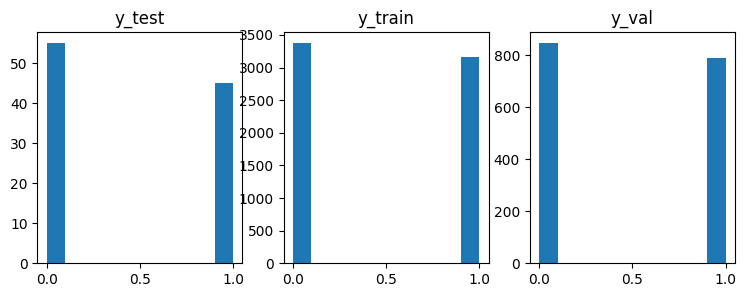

In [17]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.hist(y_test)
plt.title('y_test')
plt.subplot(132)
plt.hist(y_train)
plt.title('y_train')
plt.subplot(133)
plt.hist(y_val)
plt.title('y_val')
plt.show()

## 1.4. Векторизация и эмбеддинги

In [18]:
max_tokens_count = 90000 # Максимальный размер словаря нашего датасета ~91000 мы возьмем ТОП самых часто встречающихся токенов
# Создадим слой TextVectorization
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens_count, # Максимальный размер словаря
                                           output_sequence_length=token_len, # максимальное количество токенов
                                           standardize=None) # Не используем стандартизацию т.к. уже преобразовали данные
text_vectorizer.adapt(X_train) # Формирование словаря

2023-11-08 08:27:43.117022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-08 08:27:43.117104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: rsr-gpu
2023-11-08 08:27:43.117119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: rsr-gpu
2023-11-08 08:27:43.117405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-11-08 08:27:43.117459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.113.1
2023-11-08 08:27:43.117470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.113.1 does not match DSO version 535.129.3 -- cannot find working devices in this configuration


In [19]:
token_embed = layers.Embedding(input_dim=max_tokens_count, # Максимальный размер словаря
                               output_dim=16, # Количество эмбеддингов
                               mask_zero=True)

## 1.5. Создание и обучение модели

In [20]:
def plot_training_stat(model_history):
    # Loss
    plt.plot(model_history.history['loss'], label='loss')
    plt.plot(model_history.history['val_loss'], label='val_loss')
    plt.title('Статистика обучения модели (loss)')
    plt.ylabel('value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()
    
    # Accuracy
    plt.plot(model_history.history['accuracy'], label='accuracy')
    plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
    plt.title('Статистика обучения модели (accuracy)')
    plt.ylabel('value')
    plt.xlabel('No. epoch')
    plt.legend(loc="lower right")
    plt.show()

### 1.5.1. Как в статье

In [21]:
# Отдельно сохраняем валидационные метки, далее будем использовать для тестирования модели.
val_labels_encoded = y_val

# Кодируем метки OneHotEncoder
train_labels = pd.DataFrame(y_train)
val_labels = pd.DataFrame(y_val)
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
val_labels = one_hot_encoder.transform(y_val.to_numpy().reshape(-1, 1))

# Формируем датасеты для тренировки, валидации и проверки
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test))
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [22]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Слой TextVectorization
token_embeddings = token_embed(text_vectors) # Слой Embedding
model = layers.Convolution1D(32, kernel_size=32, padding="same",activation="relu")(token_embeddings)
model = layers.MaxPooling1D(pool_size=(2))(model)
model = layers.Bidirectional(layers.LSTM(16))(model)
outputs = layers.Dense(2, activation="softmax")(model)
model_angara = tf.keras.Model(inputs, outputs)

model_angara.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=["accuracy"])
print(model_angara.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 2000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2000, 16)          1440000   
                                                                 
 conv1d (Conv1D)             (None, 2000, 32)          16416     
                                                                 
 max_pooling1d (MaxPooling1  (None, 1000, 32)          0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 32)                6272  

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_angara',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [24]:
model_history = model_angara.fit(train_dataset,
                              epochs=15,
                              validation_data=val_dataset,
                              callbacks=[checkpoint])

plot_training_stat(model_history)

Epoch 1/15
409/409 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.9292INFO:tensorflow:Assets written to: model_angara/assets


INFO:tensorflow:Assets written to: model_angara/assets


409/409 [==============================] - 48s 114ms/step - loss: 0.3717 - accuracy: 0.9292 - val_loss: 0.0790 - val_accuracy: 0.9920
Epoch 2/15
409/409 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9956INFO:tensorflow:Assets written to: model_angara/assets


INFO:tensorflow:Assets written to: model_angara/assets


409/409 [==============================] - 46s 113ms/step - loss: 0.0476 - accuracy: 0.9956 - val_loss: 0.0296 - val_accuracy: 0.9951
Epoch 3/15
409/409 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9969INFO:tensorflow:Assets written to: model_angara/assets


INFO:tensorflow:Assets written to: model_angara/assets


409/409 [==============================] - 46s 112ms/step - loss: 0.0232 - accuracy: 0.9969 - val_loss: 0.0179 - val_accuracy: 0.9976
Epoch 4/15
409/409 [==============================] - 42s 103ms/step - loss: 0.0136 - accuracy: 0.9983 - val_loss: 0.0135 - val_accuracy: 0.9976
Epoch 5/15
409/409 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9992INFO:tensorflow:Assets written to: model_angara/assets


INFO:tensorflow:Assets written to: model_angara/assets


409/409 [==============================] - 46s 112ms/step - loss: 0.0088 - accuracy: 0.9992 - val_loss: 0.0110 - val_accuracy: 0.9982
Epoch 6/15
409/409 [==============================] - 43s 104ms/step - loss: 0.0070 - accuracy: 0.9994 - val_loss: 0.0100 - val_accuracy: 0.9982
Epoch 7/15
409/409 [==============================] - 42s 104ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0097 - val_accuracy: 0.9982
Epoch 8/15
114/409 [=======>......................] - ETA: 29s - loss: 0.0056 - accuracy: 0.9995

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Функция для подготовки результатов обучения модели
def calculate_results(y_true, y_pred):
    # Расчет accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Расчет precision, recall, f1
    model_precision, model_recall, model_f1, support = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

def get_predict(model, X_test, ohe=True):
    test_model = tf.keras.models.load_model(model)
    
    if ohe:
        model_test_probs = test_model.predict(X_test)
        model_test_preds = tf.argmax(model_test_probs, axis=1)  
        model_test_probs = [res[1] for res in model_test_probs]
    else:
        model_test_probs = test_model.predict(X_test).squeeze()
        model_test_preds = [int(res>=0.5) for res in model_test_probs]
        
        
    return model_test_probs, model_test_preds

def show_results(model_name, X_test, y_test, X_val, y_val):
        
    print('Тестирование модели на тестовых данных')
    
    model_test_probs, model_test_preds = get_predict(
        model_name, X_test, ohe=model_name.find("simple")<0)

    model_test_results = calculate_results(y_true=y_test,
                                           y_pred=model_test_preds)
    
    print('Результаты тестирования: \n', model_test_results)
    cm = confusion_matrix(y_test, model_test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('Тестирование модели на валидационных данных')
    model_val_probs, model_val_preds = get_predict(
        model_name, X_val, ohe=model_name.find("simple")<0)

    model_val_results = calculate_results(y_true=y_val,
                                           y_pred=model_val_preds)    
    
    print('Результаты тестирования: \n', model_test_results)
    cm = confusion_matrix(y_val, model_val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    plt.hist(model_val_probs, bins=100)
    plt.title("Распределение вероятности")
    plt.show()

Тестирование модели на тестовых данных
7/7 [==============================] - 0s 17ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


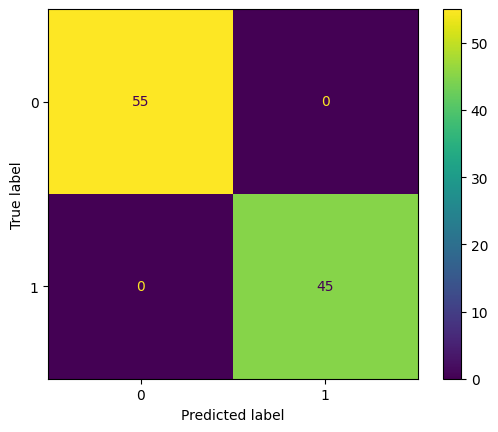

Тестирование модели на валидационных данных
103/103 [==============================] - 2s 17ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


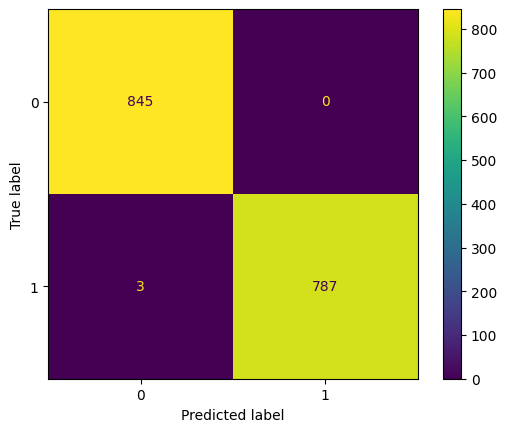

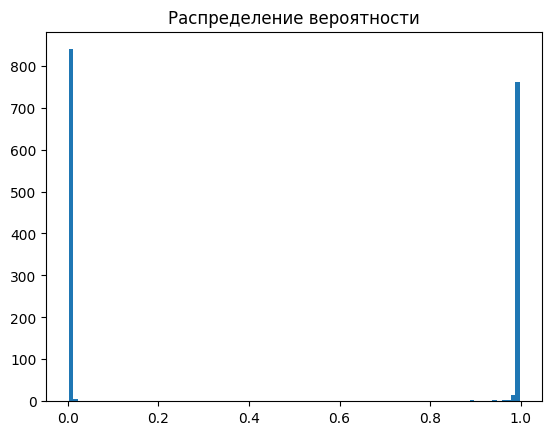

In [26]:
show_results("model_angara", test_dataset, y_test, val_dataset, y_val)

### 1.5.2. Без всяких там prefetch

Вместо того, чтобы разбираться с функциональностью prefetch, я вследствие лени решил просто повторить код без prefetch

In [27]:
# Отдельно сохраняем валидационные метки, далее будем использовать для тестирования модели.
val_labels_encoded = y_val

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
val_labels = one_hot_encoder.transform(y_val.to_numpy().reshape(-1, 1))

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Слой TextVectorization
token_embeddings = token_embed(text_vectors) # Слой Embedding
model = layers.Convolution1D(32, kernel_size=32, padding="same",activation="relu")(token_embeddings)
model = layers.MaxPooling1D(pool_size=(2))(model)
model = layers.Bidirectional(layers.LSTM(16))(model)
outputs = layers.Dense(2, activation="softmax")(model)
model_angara_lite = tf.keras.Model(inputs, outputs)

model_angara_lite.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=["accuracy"])
print(model_angara_lite.summary())

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_angara_lite',
                                                monitor='val_accuracy',
                                                save_best_only=True)

model_history = model_angara_lite.fit(X_train, train_labels,
                              epochs=15,
                              validation_data=(X_val, val_labels),
                              callbacks=[checkpoint])

plot_training_stat(model_history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 2000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2000, 16)          1440000   
                                                                 
 conv1d_1 (Conv1D)           (None, 2000, 32)          16416     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1000, 32)          0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                6272

INFO:tensorflow:Assets written to: model_angara_lite/assets


205/205 [==============================] - 33s 153ms/step - loss: 0.4867 - accuracy: 0.9752 - val_loss: 0.2785 - val_accuracy: 0.9969
Epoch 2/15
205/205 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9982INFO:tensorflow:Assets written to: model_angara_lite/assets


INFO:tensorflow:Assets written to: model_angara_lite/assets


205/205 [==============================] - 31s 150ms/step - loss: 0.1705 - accuracy: 0.9982 - val_loss: 0.1041 - val_accuracy: 0.9982
Epoch 3/15
205/205 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9994INFO:tensorflow:Assets written to: model_angara_lite/assets


INFO:tensorflow:Assets written to: model_angara_lite/assets


205/205 [==============================] - 31s 150ms/step - loss: 0.0738 - accuracy: 0.9994 - val_loss: 0.0548 - val_accuracy: 0.9988
Epoch 4/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0409 - accuracy: 0.9994 - val_loss: 0.0333 - val_accuracy: 0.9988
Epoch 5/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0257 - accuracy: 0.9997 - val_loss: 0.0224 - val_accuracy: 0.9988
Epoch 6/15
205/205 [==============================] - 27s 132ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9988
Epoch 7/15
205/205 [==============================] - 27s 132ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 0.9988
Epoch 8/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9988
Epoch 9/15
205/205 [==============================] - 27s 132ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Тестирование модели на тестовых данных
7/7 [==============================] - 0s 18ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


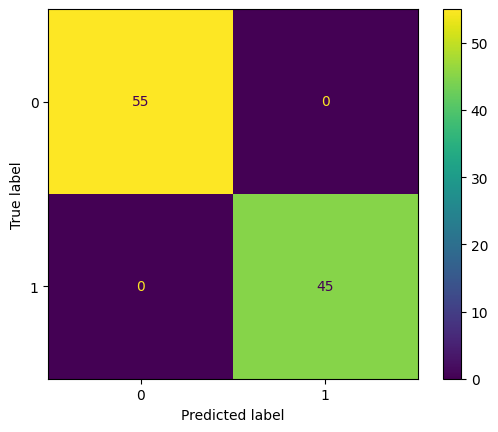

Тестирование модели на валидационных данных
103/103 [==============================] - 2s 17ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


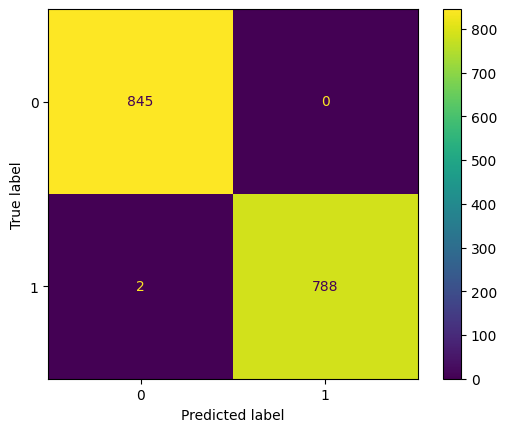

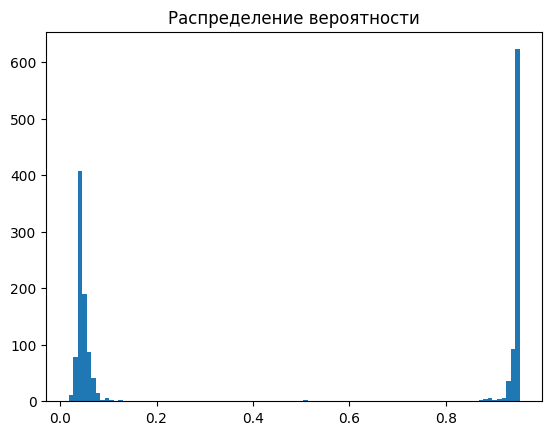

In [28]:
show_results("model_angara_lite", test_dataset, y_test, val_dataset, y_val)

**Вывод:** Результаты принципиально не различаются, у упрощенной модели они чуть лучше, но и разброс вероятностей по классу 0 хуже. ЗАто обучается быстрее

### 1.5.3. Упрощенка

т.к. Было неочевидно преобразование целевого признака с использованием one hot encoding, то я на всякий случай попробовал отказаться от этого преобразования (было target-> ohe+softmax+categorical_crossentropy, стало targer -> sigmoid+binary_crossentropy)

In [29]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Слой TextVectorization
token_embeddings = token_embed(text_vectors) # Слой Embedding
model = layers.Convolution1D(32, kernel_size=32, padding="same",activation="relu")(token_embeddings)
model = layers.MaxPooling1D(pool_size=(2))(model)
model = layers.Bidirectional(layers.LSTM(16))(model)
outputs = layers.Dense(1, activation="sigmoid")(model)
model_simple = tf.keras.Model(inputs, outputs)

model_simple.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=["accuracy"])
print(model_simple.summary())

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_simple',
                                                monitor='val_accuracy',
                                                save_best_only=True)

model_history = model_simple.fit(X_train, y_train,
                              epochs=15,
                              validation_data=(X_val, y_val),
                              callbacks=[checkpoint]
                              )

plot_training_stat(model_history)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 2000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2000, 16)          1440000   
                                                                 
 conv1d_2 (Conv1D)           (None, 2000, 32)          16416     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1000, 32)          0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                6272

INFO:tensorflow:Assets written to: model_simple/assets


205/205 [==============================] - 33s 153ms/step - loss: 0.4014 - accuracy: 0.9939 - val_loss: 0.1855 - val_accuracy: 0.9976
Epoch 2/15
205/205 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9980INFO:tensorflow:Assets written to: model_simple/assets


INFO:tensorflow:Assets written to: model_simple/assets


205/205 [==============================] - 31s 151ms/step - loss: 0.1218 - accuracy: 0.9980 - val_loss: 0.0842 - val_accuracy: 0.9988
Epoch 3/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0639 - accuracy: 0.9989 - val_loss: 0.0512 - val_accuracy: 0.9982
Epoch 4/15
205/205 [==============================] - 27s 132ms/step - loss: 0.0408 - accuracy: 0.9994 - val_loss: 0.0352 - val_accuracy: 0.9988
Epoch 5/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0287 - accuracy: 0.9995 - val_loss: 0.0262 - val_accuracy: 0.9988
Epoch 6/15
205/205 [==============================] - 27s 132ms/step - loss: 0.0213 - accuracy: 0.9995 - val_loss: 0.0208 - val_accuracy: 0.9988
Epoch 7/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0163 - accuracy: 0.9995 - val_loss: 0.0172 - val_accuracy: 0.9988
Epoch 8/15
205/205 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9995INFO:tensorflow:Assets written to: model_simpl

INFO:tensorflow:Assets written to: model_simple/assets


205/205 [==============================] - 31s 150ms/step - loss: 0.0129 - accuracy: 0.9995 - val_loss: 0.0144 - val_accuracy: 0.9994
Epoch 9/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9988
Epoch 10/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9988
Epoch 11/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9988
Epoch 12/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9988
Epoch 13/15
205/205 [==============================] - 27s 132ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9988
Epoch 14/15
205/205 [==============================] - 27s 133ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Тестирование модели на тестовых данных
4/4 [==============================] - 0s 22ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


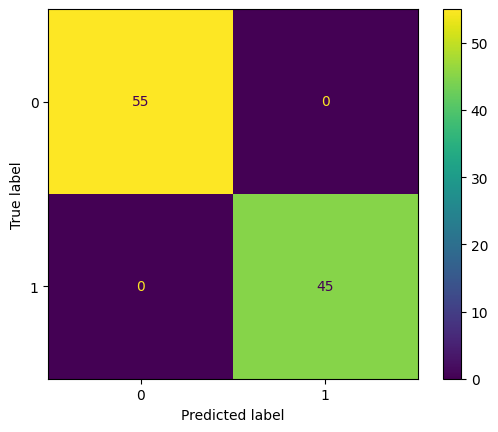

Тестирование модели на валидационных данных
52/52 [==============================] - 1s 23ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


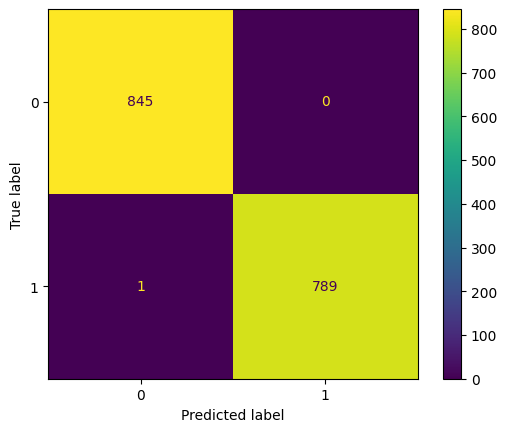

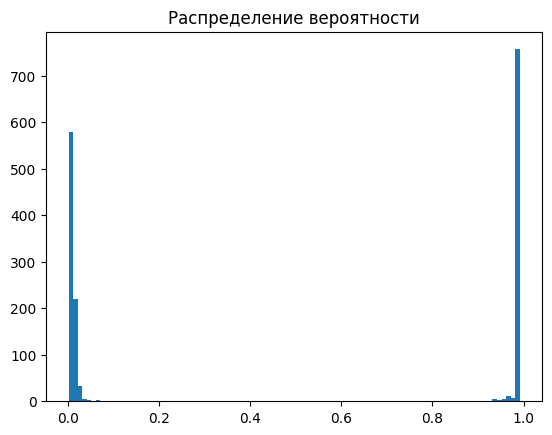

In [30]:
show_results("model_simple", X_test, y_test, X_val, y_val)

**Вывод:** принципиальных отличий также нет, результаты даже чуть лучше

# Выводы
1. Подход, реализованный специалистами Ангары - сильно упрощенная версия оригинального подхода, изложенного в статье. В нем не учитывается то, что скрипты могут быть разбиты на несколько сообщений, а, главное, никак не обучаются эмбеддинги
2. Найденные моделью, обученной на тренировочных датасетах, вредоносные скрипты из реальных данных SOC на самом деле не являются таковыми. Это вероятно является следствием недостаточного разнообразных скриптов в обучающем датасете, а также упрощенным подходом, который предложили ребята из Ангары
3. Данный подход можно развивать дальше для выявления вредоносов в скриптах, но с т.з. бизнес-процесса для SOC данная задача не является приоритетной, т.к. выявление вредоносных скриптов обычно выполняется локально